# EDA

In [2]:
import chess
import chess.pgn
import pandas as pd
import numpy as np

In [3]:
# Define the path to the PGN file
pgn_file_path = r'C:\Users\edulo\OneDrive\Documentos\Loyalist\AIP\Week 5\ds\ficsgamesdb_2023_standard2000_movetimes_390744.pgn'

# Function to convert time string to seconds
def convert_time_to_seconds(time_str):
    try:
        if ':' in time_str:
            h, m, s = map(float, time_str.split(':'))
            return h * 3600 + m * 60 + s
        return float(time_str)  # Handle cases where only seconds are provided
    except:
        return 0  # Default to 0 if conversion fails

# Initializing lists to store game data
games_data = []

# Open the PGN file and parse games
with open(pgn_file_path, 'r', encoding='utf-8-sig') as pgn_file:
    while True:
        game = chess.pgn.read_game(pgn_file)
        if game is None:
            break

        game_info = {
            'Event': game.headers.get('Event'),
            'Site': game.headers.get('Site'),
            'Date': game.headers.get('Date'),
            'White': game.headers.get('White'),
            'Black': game.headers.get('Black'),
            'WhiteElo': int(game.headers.get('WhiteElo', 0)),
            'BlackElo': int(game.headers.get('BlackElo', 0)),
            'TimeControl': game.headers.get('TimeControl'),
            'Result': game.headers.get('Result'),
            'PlyCount': int(game.headers.get('PlyCount', 0)),
            'ECO': game.headers.get('ECO', 'Unknown'),
            'Moves': [],
            'Times': []
        }

        # Extract moves and times
        node = game
        while not node.is_end():
            next_node = node.variation(0)
            move = node.board().san(next_node.move)
            move_time = next_node.comment.replace('[%emt ', '').replace(']', '').strip()
            game_info['Moves'].append(move)
            game_info['Times'].append(move_time if move_time else '0:00:00')  # Default to '0:00:00' if empty
            node = next_node

        games_data.append(game_info)

# Convert to DataFrame
df = pd.DataFrame(games_data)

In [4]:
total_games = len(df)
print(f'Total number of games: {total_games}')

Total number of games: 19686


In [5]:
df['Times'] = df['Times'].apply(lambda x: [convert_time_to_seconds(t) for t in x])

def average_time(moves, times):
    valid_times = [t for t in times[:moves] if t is not None]
    return sum(valid_times) / len(valid_times) if valid_times else 0

df['AvgTimeFirst5'] = df['Times'].apply(lambda x: average_time(5, x))
df['AvgTimeFirst10'] = df['Times'].apply(lambda x: average_time(10, x))
df['AvgTimeFirst20'] = df['Times'].apply(lambda x: average_time(20, x))

avg_time_first_5 = df['AvgTimeFirst5'].mean()
avg_time_first_10 = df['AvgTimeFirst10'].mean()
avg_time_first_20 = df['AvgTimeFirst20'].mean()

print(f'Average time for the first 5 moves: {avg_time_first_5} seconds')
print(f'Average time for the first 10 moves: {avg_time_first_10} seconds')
print(f'Average time for the first 20 moves: {avg_time_first_20} seconds')

Average time for the first 5 moves: 2.2389591587930506 seconds
Average time for the first 10 moves: 3.982530913919972 seconds
Average time for the first 20 moves: 8.703011332299685 seconds


In [6]:
# Average game duration
df['GameDuration'] = df['Times'].apply(lambda x: sum(t for t in x if t is not None))
avg_game_duration = df['GameDuration'].mean()
print(f'Average game duration: {avg_game_duration} seconds')

# Distribution of results
result_distribution = df['Result'].value_counts()
print('Result distribution:')
print(result_distribution)

# Impact of Elo ratings on move times
df['AvgMoveTime'] = df['GameDuration'] / df['PlyCount']
df['WhiteElo'] = df['WhiteElo'].fillna(0)
df['BlackElo'] = df['BlackElo'].fillna(0)
df['AvgMoveTime'] = df['AvgMoveTime'].fillna(0)

correlation_white_elo = df[['WhiteElo', 'AvgMoveTime']].corr().iloc[0, 1]
correlation_black_elo = df[['BlackElo', 'AvgMoveTime']].corr().iloc[0, 1]

print(f'Correlation between White Elo and average move time: {correlation_white_elo}')
print(f'Correlation between Black Elo and average move time: {correlation_black_elo}')

Average game duration: 1432.0949405669003 seconds
Result distribution:
Result
1-0        8509
0-1        8293
1/2-1/2    2884
Name: count, dtype: int64
Correlation between White Elo and average move time: 0.26123117089315456
Correlation between Black Elo and average move time: 0.23247738331719875


In [7]:
def average_time_last(moves, times):
    valid_times = [t for t in times[-moves:] if t is not None]
    return sum(valid_times) / len(valid_times) if valid_times else None

df['AvgTimeLast5'] = df['Times'].apply(lambda x: average_time_last(5, x))
df['AvgTimeLast10'] = df['Times'].apply(lambda x: average_time_last(10, x))
df['AvgTimeLast20'] = df['Times'].apply(lambda x: average_time_last(20, x))

avg_time_last_5 = df['AvgTimeLast5'].mean()
avg_time_last_10 = df['AvgTimeLast10'].mean()
avg_time_last_20 = df['AvgTimeLast20'].mean()

print(f'Average time for the last 5 moves: {avg_time_last_5} seconds')
print(f'Average time for the last 10 moves: {avg_time_last_10} seconds')
print(f'Average time for the last 20 moves: {avg_time_last_20} seconds')

Average time for the last 5 moves: 10.413364747834947 seconds
Average time for the last 10 moves: 13.345333854886833 seconds
Average time for the last 20 moves: 15.405088185820254 seconds


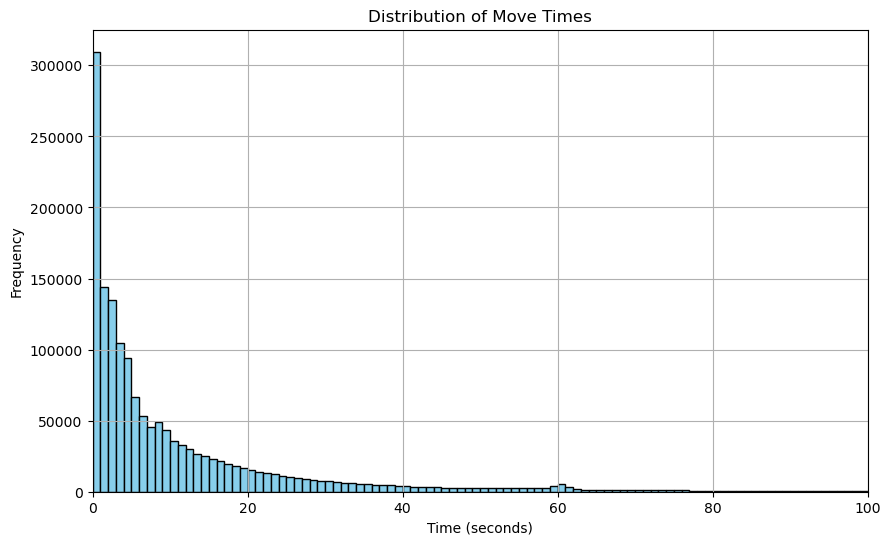

In [8]:
import matplotlib.pyplot as plt

# Plotting distribution of move times
plt.figure(figsize=(10, 6))
plt.hist(df['Times'].explode().dropna().astype(float), bins=range(0, 101), color='skyblue', edgecolor='black')
plt.title('Distribution of Move Times')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0, 100)  # Set the x-axis limits
plt.show()


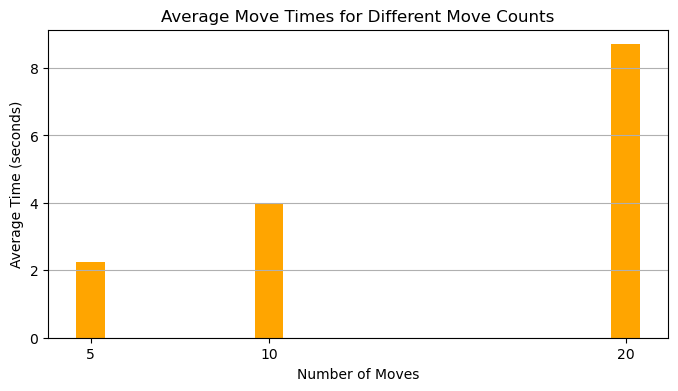

In [9]:
# Plotting average move times
move_counts = [5, 10, 20]
avg_times = [avg_time_first_5, avg_time_first_10, avg_time_first_20]
plt.figure(figsize=(8, 4))
plt.bar(move_counts, avg_times, color='orange')
plt.title('Average Move Times for Different Move Counts')
plt.xlabel('Number of Moves')
plt.ylabel('Average Time (seconds)')
plt.xticks(move_counts)
plt.grid(axis='y')
plt.show()

In [10]:
# Total number of moves
total_moves = sum(df['PlyCount'])
print(f'Total number of moves in the file: {total_moves}')

# Count of moves made in 0 seconds
zero_second_moves = sum(1 for moves in df['Times'] for move in moves if move == 0)
print(f'Number of moves made in 0 seconds: {zero_second_moves}')

Total number of moves in the file: 1600300
Number of moves made in 0 seconds: 309581


In [11]:
# Calculate percentage of moves over 0 seconds
percentage_over_0_seconds = ((total_moves - zero_second_moves) / total_moves) * 100
print(f'Percentage of moves over 0 seconds: {percentage_over_0_seconds:.2f}%')


Percentage of moves over 0 seconds: 80.65%


# Feature Eng

In [13]:
import pandas as pd
import chess.pgn

# Parsing time control from PGN tag
def parse_time_control(time_control):
    parts = time_control.split('+')
    initial_time = int(parts[0])
    additional_time_per_move = int(parts[1])
    return initial_time, additional_time_per_move

# Parsing time taken from PGN comment
def parse_time(comment):
    if "[%emt" in comment:
        time_str = comment.split('[%emt ')[1].split(']')[0]
        parts = time_str.split(':')
        if len(parts) == 3:
            hours, minutes, seconds = map(float, parts)
            total_seconds = hours * 3600 + minutes * 60 + seconds
        elif len(parts) == 2:
            minutes, seconds = map(float, parts)
            total_seconds = minutes * 60 + seconds
        else:
            total_seconds = float(parts[0])
        return total_seconds
    return 0

# Reading the PGN file
pgn_file_path = r'C:\Users\edulo\OneDrive\Documentos\Loyalist\AIP\Week 5\ds\ficsgamesdb_2023_standard2000_movetimes_390744.pgn'

# Initializing the DataFrame
data = []

# Openning PGN file
with open(pgn_file_path, 'r') as pgn_file:
    while True:
        # Read each game from the PGN file
        game = chess.pgn.read_game(pgn_file)
        
        # If no game is found, break the loop
        if game is None:
            break
        
        # Getting the game ID
        game_id = int(game.headers['FICSGamesDBGameNo'])
        
        # Parse the time control
        time_control = game.headers['TimeControl']
        initial_time, additional_time_per_move = parse_time_control(time_control)
        
        # Initializing the board for the current game
        board = game.board()
        prev_fen = board.fen()
        time_left_white = initial_time
        time_left_black = initial_time
        drop_game = False
        move_count = 0
        
        # Iterating through each move in the current game
        for node in game.mainline():
            move = node.move
            comment = node.comment
            time_taken = parse_time(comment)
            
            # Incrementing move count for each player
            if board.turn:
                move_count += 1
            
            # Updating time left for the player making the move
            if board.turn:
                time_left_white -= time_taken
                time_left_white += additional_time_per_move
                if time_left_white < 0:
                    drop_game = True
                    break
            else:
                time_left_black -= time_taken
                time_left_black += additional_time_per_move
                if time_left_black < 0:
                    drop_game = True
                    break
            
            # Updating the board with the current move
            board.push(move)
            curr_fen = board.fen()
            
            # Append the data to the list
            data.append([game_id, prev_fen, curr_fen, int(board.turn), move_count, time_left_white, time_left_black, time_taken])
            
            # Updating the previous FEN for the next move
            prev_fen = curr_fen
        
        # If drop_game is True, skip appending data for this game
        if drop_game:
            continue

# Creating a DataFrame from the collected data
df = pd.DataFrame(data, columns=['FICSGamesDBGameNo', 'previous_state', 'current_state', 'color', 'move_count', 'time_left_white', 'time_left_black', 'time_taken'])

# Check the DataFrame structure
print(df.head())

   FICSGamesDBGameNo                                     previous_state  \
0          700000486  rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...   
1          700000486  rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...   
2          700000486  rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBN...   
3          700000486  rnbqkbnr/ppp1pppp/8/3p4/3P4/5N2/PPP1PPPP/RNBQK...   
4          700000486  rnbqkb1r/ppp1pppp/5n2/3p4/3P4/5N2/PPP1PPPP/RNB...   

                                       current_state  color  move_count  \
0  rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...      0           1   
1  rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBN...      1           1   
2  rnbqkbnr/ppp1pppp/8/3p4/3P4/5N2/PPP1PPPP/RNBQK...      0           2   
3  rnbqkb1r/ppp1pppp/5n2/3p4/3P4/5N2/PPP1PPPP/RNB...      1           2   
4  rnbqkb1r/ppp1pppp/5n2/3p4/3P4/5NP1/PPP1PP1P/RN...      0           3   

   time_left_white  time_left_black  time_taken  
0           1845.0           1800.0         0.0 

In [14]:
#Testing FEN format

import chess

# FEN representation
fen_str = "rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1"

# Create a chess board from FEN
board = chess.Board(fen_str)

# Print the chess board
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R


In [15]:
import pandas as pd
import numpy as np
import chess

In [16]:
# Function to convert board state to one-hot encoding
def board_to_one_hot(board):
    one_hot = np.zeros((8, 8, 12), dtype=np.int8)
    piece_map = {chess.PAWN: 0, chess.KNIGHT: 1, chess.BISHOP: 2,
                 chess.ROOK: 3, chess.QUEEN: 4, chess.KING: 5}
    for square in chess.scan_reversed(chess.BB_ALL):
        piece = board.piece_at(square)
        if piece is not None:
            piece_index = piece_map[piece.piece_type] + (6 if piece.color else 0)
            one_hot[chess.square_rank(square), chess.square_file(square), piece_index] = 1
    return one_hot

In [17]:
# Loop through each row in the DataFrame
for index, row in df.iterrows():
    # Get FEN representation of previous and current states
    prev_fen = row['previous_state']
    curr_fen = row['current_state']
    
    # Create board objects from FEN strings
    prev_board = chess.Board(prev_fen)
    curr_board = chess.Board(curr_fen)
    
    # Convert FEN representation to one-hot encoding
    prev_one_hot = board_to_one_hot(prev_board)
    curr_one_hot = board_to_one_hot(curr_board)
    
    # Update DataFrame with one-hot encoded states
    df.at[index, 'previous_state'] = prev_one_hot
    df.at[index, 'current_state'] = curr_one_hot

# Check the updated DataFrame structure
print(df.head())

   FICSGamesDBGameNo                                     previous_state  \
0          700000486  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...   
1          700000486  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...   
2          700000486  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...   
3          700000486  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...   
4          700000486  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...   

                                       current_state  color  move_count  \
0  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...      0           1   
1  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...      1           1   
2  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...      0           2   
3  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...      1           2   
4  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...      0           3   

   time_left_white  time_left_black  time_taken  
0           1845.0           1800.0         0.0 

# Model Building

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [24]:
# Data preprocessing
X = df.drop(columns=['FICSGamesDBGameNo', 'time_taken', 'color'])
y = df['time_taken']

In [26]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    return model

input_shape = (8, 8, 64)

# Create an instance of the CNN model
model = create_cnn_model(input_shape)